This notebook aims to fit the general LNOx profile for TROPOMI AMF calculation.

## Literature LNOx profile

In [1]:
import pandas as pd
from  metpy.calc import height_to_pressure_std
from metpy.units import units

from distfit import distfit
import numpy as np
import proplot as pplt
import matplotlib.pyplot as plt

Data from Ott (2010), Pickering (1998), and Luo (2016):

In [2]:
z = (np.arange(0, 18)[:-1]+np.arange(0, 18)[1:])/2
p = height_to_pressure_std(z*units.kilometer).magnitude

df_luo = pd.read_csv('../data/luo_2016.csv', header=None, names=['lnox', 'height'])
p_luo = height_to_pressure_std(df_luo['height'].values*units.kilometer).magnitude

ott_subtrop = np.array([1.0, 2.1, 3.9, 5.8,  7.7,  9.3, 10.5, 11.0, 11.0, 10.4, 9.2,   7.5,  5.5,  3.4, 1.5,  .2, 0.0])
ott_midlat  = np.array([2.4, 5.0, 7.4, 9.3, 10.6, 11.4, 11.5, 11.0,  9.9,  8.3, 6.3,   4.2,  2.2,  0.5, 0.0, 0.0, 0.0])
ott_trpcon  = np.array([.2,   .5,  .6, 1.4,  2.7,  4.0,  5.0,  6.2,  8.6, 10.3, 11.6, 12.4, 12.7, 12.4, 7.6, 3.0, .8])
ott_trpmar  = np.array([.6,  1.5, 2.9, 4.3,  5.4,  6.7,  7.7,  8.5,  9.6, 10.2, 10.5, 10.2,  8.2,  6.5, 4.5, 2.2, .5])

ott_midlat_mod = np.array([3.0, 4.7, 6.4, 10.1, 13.0, 11.5, 8.8, 9.3, 11.4, 11.1, 7.0, 2.3, 0.9, 0.6, 0.0, 0.0, 0.0]) # the two-bump profile

pickering_midlat  = np.array([20.1, 2.3, 0.8, 1.5, 3.4,  5.3,  3.6,  3.8,  5.4,  6.6,  8.3,   9.6,  12.8,  10.0, 6.2, 0.3, 0.0])
pickering_trpcon  = np.array([8.2,  1.9, 2.1, 1.6, 1.1,  1.6,  3.0,  5.8,  7.6,  9.6, 10.5,  12.3,  11.8,  12.5, 8.1, 2.3, 0.0])
pickering_trpmar  = np.array([5.8,  2.9, 2.6, 2.4, 2.2,  2.1,  2.3,  6.1, 16.5, 14.1, 13.7,  12.8,  12.5,   2.8, 0.9, 0.3, 0.0])

In [3]:
# # https://github.com/wrf-model/WRF/pull/1696

# fig, axs = pplt.subplots(ncols=2)

# z = (np.arange(0, 18)[:-1]+np.arange(0, 18)[1:])/2

# ax = axs[0]
# l_subtrop = axs.plot(ott_subtrop, z, label='Subtropical')
# l_midlat = axs.plot(ott_midlat, z, label='Midlatitude')
# # axs.plot(ott_midlat_mod, z, label='Midlatitude-mod')
# l_trpcon = axs.plot(ott_trpcon, z, label='Tropical (Continental)')
# l_trpmar_false = ax.plot(ott_trpmar_false, z, label='Tropical (Marine)')

# ax = axs[1]
# l_trpmar = ax.plot(ott_trpmar, z, label='Tropical (Marine)')


# fig.legend([l_subtrop[0], l_midlat[0], l_trpcon[0], l_trpmar], loc='r', ncols=1)
# axs.format(xlim =(0, 0.2), ylim=(0, 17), title=['Wrong', 'Correct'])

[ 10.10181113 350.99788612 192.6540299 ]
peak width:  192
[ 12.38268364 249.97546858 118.26705068]
peak width:  118
[ 12.44315475 500.         199.52044726]
peak width:  199
[ 10.70991091 254.05744799 153.24698645]
peak width:  153


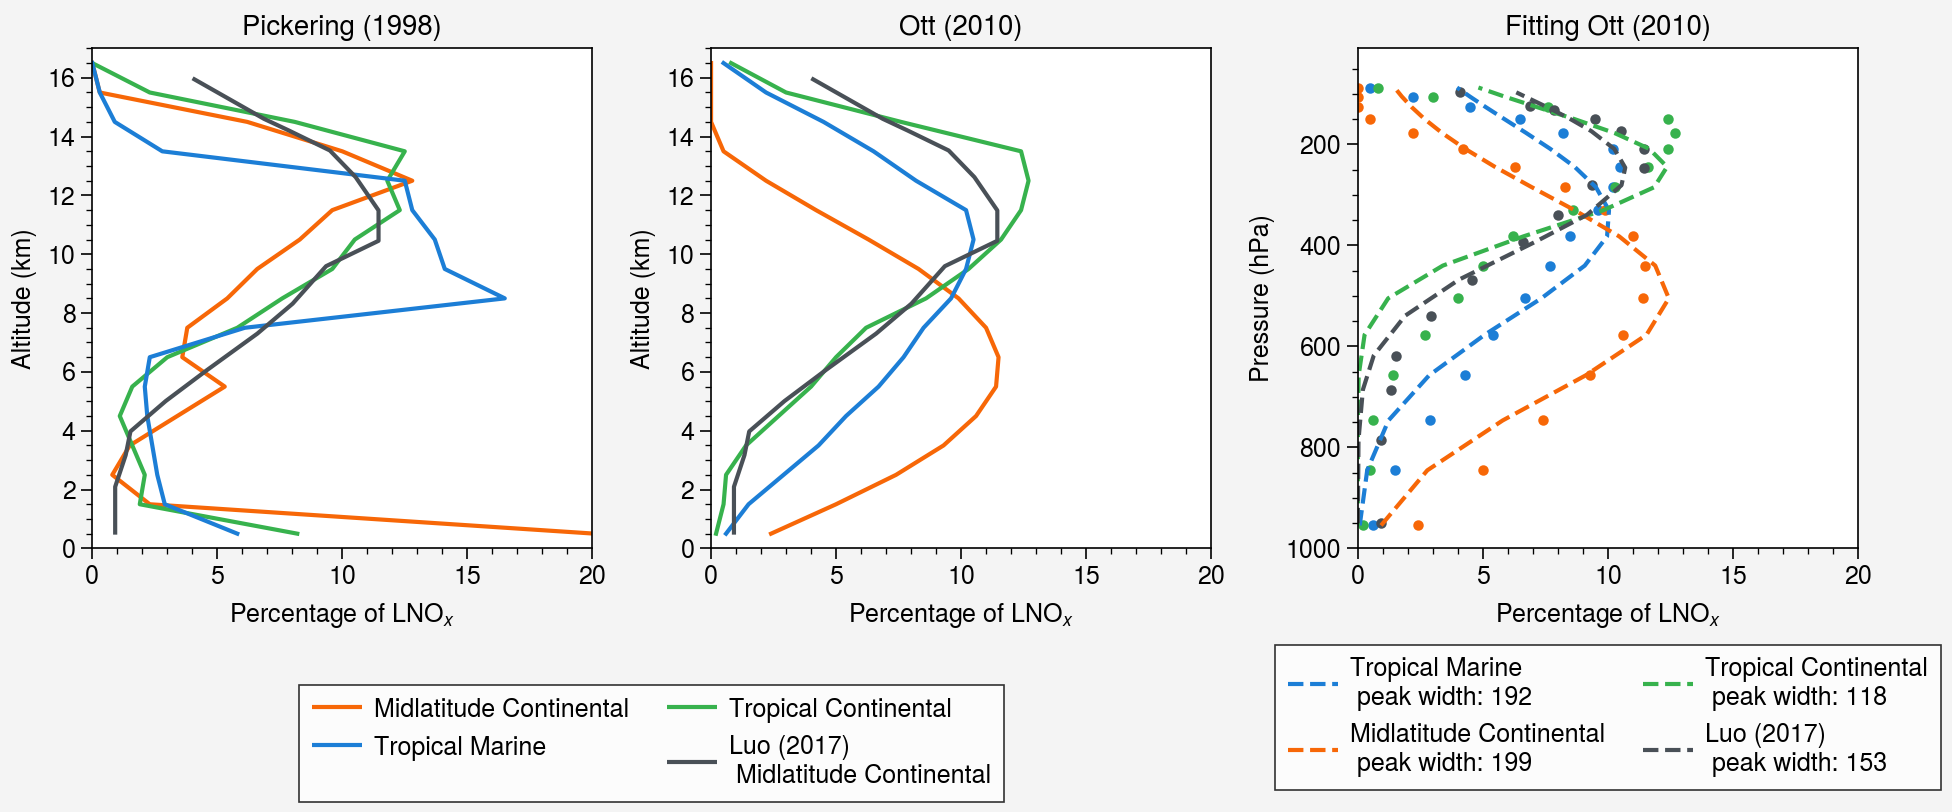

In [4]:
fig, axs = pplt.subplots(ncols=3, share=0)

c_subtrop = 'gray7'
c_midlat = 'orange7'
c_tropland = 'green7'
c_tropocean = 'blue7'

ax = axs[0]
ax.plot(pickering_midlat, z, c=c_midlat, label='Midlatitude Continental')
ax.plot(pickering_trpcon, z, c=c_tropland, label='Tropical Continental')
ax.plot(pickering_trpmar, z, c=c_tropocean, label='Tropical Marine')


ax = axs[1]
l1 = ax.plot(ott_midlat, z, c=c_midlat, label='Midlatitude Continental')
l2 = ax.plot(ott_trpcon, z, c=c_tropland, label='Tropical Continental')
l3 = ax.plot(ott_trpmar, z, c=c_tropocean, label='Tropical Marine')

l4 = axs[:2].plot(df_luo['lnox'], df_luo['height'], c='gray7', label='Luo (2017) \n Midlatitude Continental')

fig.legend([l1, l2, l3, l4[0]], cols=(1, 2), loc='b', ncols=2)

# Fit profiles using Gaussian function
# Function to calculate the Gaussian with constants a, b, and c
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

from scipy.optimize import curve_fit

# Plot the noisy exponential data
colors  = ['blue7', 'green7', 'orange7']
labels = ['Tropical Marine', 'Tropical Continental', 'Midlatitude Continental']

ax = axs[2]
for index,ydata in enumerate([ott_trpmar, ott_trpcon, ott_midlat]):
    ax.scatter(ydata, p, s=10, c=colors[index])
    pars, cov = curve_fit(f=gaussian, xdata=p, ydata=ydata, bounds=((-np.inf, 200, 50), (np.inf, 500, 250)))
    print(pars)
    peak_width = int(pars[-1])
    print('peak width: ', peak_width)
    ax.plot(gaussian(p, *pars), p, linewidth=1.5, linestyle='--', c=colors[index], label=labels[index]+f'\n peak width: {peak_width}')

ax.scatter(df_luo['lnox'], p_luo, s=10, c='gray7')
pars, cov = curve_fit(f=gaussian, xdata=p_luo, ydata=df_luo['lnox'], bounds=((-np.inf, 200, 50), (np.inf, 500, 250)))
print(pars)
peak_width = int(pars[-1])
print('peak width: ', peak_width)
ax.plot(gaussian(p_luo, *pars), p_luo, linewidth=1.5, linestyle='--', c='gray7', label='Luo (2017)'+f'\n peak width: {peak_width}')


ax.legend(loc='b', ncols=2)

axs.format(xlim =(0, 20), ylim=(0, 17), grid=False,
           xlabel='Percentage of LNO$_x$', ylabel='Altitude (km)',
           title=['Pickering (1998)', 'Ott (2010)', 'Fitting Ott (2010)']
           )

ax.format(grid=False, ylim=(1000, 10), ylabel='Pressure (hPa)')

fig.savefig('../figures/lnox_profile.pdf')

We generate a priori lightning NO$_2$ (LNO$_2$) profiles for the air mass factor (AMF) algorithm by fitting them to a modified Gaussian distribution.
This distribution is given by the equation $k*e^\frac{{-{(p - peak\_pressure)}^2}}{2*peak\_width^{2}}$.

In this equation, the coefficient $k$ is cancelled out in the numerator and denominator of the AMF calculation and $p$ is the pressure levels of the tracer model, version 5, tailored for the application of satellite retrievals (TM5-MP).

We set the value of $peak\_width$ to 180 hPa, which is the mean value of the marine $peak\_width$ from \citeauthor{Ott.2010} \cite{Ott.2010} and the mid-latitude continental $peak\_width$ from \citeauthor{Luo.2017} \cite{Luo.2017} (Figure \ref{fig:lnox_profile}).

This choice is supported by the fact that the mid-latitude LNO$_x$ profile estimated by \citeauthor{Ott.2010} \cite{Ott.2010} is similar to the pre-convection profile, as indicated by the altitude distribution of lightning channel segments and discharge-dependent parameterizations \cite{Luo.2017}.

We set $peak\_pressure$ as the highest TROPOMI cloud pressure in the lightning mask.

According to the histogram of TROPOMI cloud pressure (Figure \ref{fig:pcld_ptropo}), $peak\_pressure$ is typically between 200 and 550 hPa.
The uncertainty of the LNO$_2$ production efficiency related to $peak\_width$ and cloud pressure is summarized in Table \ref{table:uncertainty}.